<a href="https://colab.research.google.com/github/prakritipaul/mhcglobe/blob/main/v2_BERT_MHCGlobe_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using BERT Features on pipeline in prakriti_MHCglobe_code_validation.

1. Got BERT embeddings for 1000 training/es_allele/peptide_pseudosxns.
2. Has new model that integrates new "preprocessing" dense layer.
3. Has (incorrect) predictions.



In [1]:
!git clone https://github.com/prakritipaul/mhcglobe.git

Cloning into 'mhcglobe'...
remote: Enumerating objects: 750, done.
remote: Counting objects: 100% (201/201), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 750 (delta 117), reused 196 (delta 115), pack-reused 549
Receiving objects: 100% (750/750), 113.03 MiB | 32.69 MiB/s, done.
Resolving deltas: 100% (415/415), done.
Updating files: 100% (200/200), done.
Error downloading object: data/distB62_unique_pseudpsequences.pkl (d151a08): Smudge error: Error downloading data/distB62_unique_pseudpsequences.pkl (d151a0800777499690d258210735bbe1bf8f627fedc59b579281582b6a03b3da): batch response: This repository is over its data quota. Account responsible for LFS bandwidth should purchase more data packs to restore access.

Errors logged to /content/mhcglobe/.git/lfs/logs/20240403T201428.428532434.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: data/distB62_unique_pseudpsequences.pkl: smudge filter lfs failed
You can i

In [46]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import joblib as jb

import sys
sys.path.append("/content/mhcglobe/src")
import mhcglobe
import mhc_data
import inequality_loss
import train_functions as trainf
import binding_affinity as ba
import sequence_functions as seqf
import prakriti_helper_functions as phf

# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Get data
Contains both BA+EL, human and non-human

In [80]:
# 729,538/1,229,838
pMHC = mhc_data.pMHC_Data(only_EL=False, drop_duplicate_records=True)
pMHC_data = pMHC.data

#### Randomly pick 100 HLA-peptide peptide + Remove them from training data
These will be the test set, and is the same number of examples as in Eric's example df.   

In [81]:
# 678024
# Note: ba = 89529 (13%), sa/ma = 588495 (87%)
human_pMHC_data = pMHC_data[pMHC_data["allele"].str.contains("HLA")]
# 12% ba's
human_pMHC_data_test = human_pMHC_data.sample(n=100, random_state=428364)

# Seeing what happens if I only have ='s
# human_pMHC_data_test = human_pMHC_data.iloc[:100]

# 729438
pMHC_data_train = pMHC_data[~pMHC_data.index.isin(human_pMHC_data_test.index)]

#### Reset Indices to prevent any issues downstream

In [82]:
pMHC_data_train = pMHC_data_train.reset_index(drop=True)
human_pMHC_data_test = human_pMHC_data_test.reset_index(drop=True)

In [ ]:
pMHC_data_train.head(10)

In [83]:
human_pMHC_data_test.head(10)

,allele,dataset,measurement_inequality,measurement_type,measurement_value,peptide,Gene,is_ABC,is_human
0,HLA-A*02:06,IEDB,<,SA,100.0,RVVDYLTKL,HLA-A,True,True
1,HLA-B*27:05,IEDB,<,SA,100.0,TRYQTFVNF,HLA-B,True,True
2,HLA-A*02:12,S3_Only,>,BA,20000.0,AARHKHQVM,HLA-A,True,True
3,HLA-B*07:02,IEDB,<,SA,100.0,IPRSILMTTF,HLA-B,True,True
4,HLA-B*27:05,S3_Only,<,SA,100.0,SRVMDFFRR,HLA-B,True,True
5,HLA-C*12:02,IEDB,<,SA,100.0,STDPRPASY,HLA-C,True,True
6,HLA-B*35:03,MHCFlury2_S1,<,MA,100.0,SPHGIASVL,HLA-B,True,True
7,HLA-B*49:01,IEDB,<,SA,100.0,IEESGEHII,HLA-B,True,True
8,HLA-A*36:01,IEDB,<,SA,100.0,SLAMEMVLTGDR,HLA-A,True,True
9,HLA-B*35:07,IEDB,<,SA,100.0,MPFDFRRFDIY,HLA-B,True,True


#### Get 4 relevant columns

In [52]:
pMHC_data_train = pMHC_data_train[["allele", "peptide", "measurement_inequality", "measurement_value"]]
human_pMHC_data_test = human_pMHC_data_test[["allele", "peptide", "measurement_inequality", "measurement_value"]]

In [ ]:
pMHC_data_train.head(10)

In [ ]:
human_pMHC_data_test.head(10)

### Balance the dataset to get X_tr, Y_tr, X_es, Y_es!


In [56]:
# Returns a data frame with cols
# test (is it es or not), allele, peptide, measurement_inequality, measurement_value
train, es = trainf.BalanceSplitData().get_train_val(pMHC_data_train)

# reset indices to prevent downstream issues
# 583650
train = train.reset_index(drop=True)
# 145788
es = es.reset_index(drop=True)

### REMOVE THIS LATER: just a test!

In [57]:
train, es = train.iloc[:1000], es.iloc[:1000]

In [ ]:
train

In [ ]:
es

### Get MHC pseudosxns (X1_train, X1_es)- should be a function
Returns a list.

In [61]:
def get_allele_pseudoseqs(train_or_es, mhc_data):
  """
    Gets pseudosquences for MHC alleles present in a train or es dataframe.

    Args:
      train_or_es: Data frame with cols
        test (is it es or not), allele, peptide, measurement_inequality, measurement_value

      mhc data object: used to make allele2seq dict.
        e.g. pMHC = mhc_data.pMHC_Data
        {'HLA-A*02:560': 'YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYEWY'...}

    Returns:
      allele_pseudoseqs: list of shape (n_alleles, 34)
"
    Example:
      'DLA-88*508:01', 'Mamu-B*08:01' -> 'YYATYGEKVETVYVDTLYITYRDYTWAVWNYTWY',
                                         'YSSEYEERAGHTDADTLYLTYHYYTWAEVAYTWY'
  """
  mhc_alleles = train_or_es["allele"]
  allele2seq_dict = mhc_data.allele2seq

  allele_pseudoseqs = [str(allele2seq_dict[a]) for a in mhc_alleles]
  return allele_pseudoseqs

In [62]:
# X1_train, X1_es
training_allele_pseudoseqs = get_allele_pseudoseqs(train, pMHC)
es_allele_pseudoseqs = get_allele_pseudoseqs(es, pMHC)

### Get MHCFlurry representations of peptides (X2_train, X2_es)
Returns a list.

Basically change "seq_to_15mer" function to just get the amino acids of the representation.

In [63]:
def get_mhcflurry_representation(peptide):
  """
    Given a peptide sequence, return the mhcflurry representation.

    Examples:
      Example 1: ARDV (4) -> ARDV-X7-ARDV
	    Example 2: ARDVA (5) -> ARDV-X7-RDVA
      Example 3: ARDVAA (6) -> ARDV-X7-DVAA
        (X7 padding is true until len(peptide) = 8)
      Example 4: ARDVAAAAA (9) -> ARDV-XXX-A-XXX-AAAA
      Example 5: ARDVAAAAAA (10) -> ARDV-XXX-AA-XX-AAAA
  """
  middle_AAs = peptide[4:-4]
  num_X = 15-(len(middle_AAs)+8)

  if num_X%2 == 0:
    pad_len = num_X//2
    middle_AAs_with_pad = "X"*pad_len + middle_AAs + "X"*pad_len

  else:
    pad_len_left = num_X//2 + 1
    pad_len_right = pad_len_left - 1
    middle_AAs_with_pad = "X"*pad_len_left + middle_AAs + "X"*pad_len_right

  mhcflurry_representation = peptide[:4] + middle_AAs_with_pad + peptide[-4:]
  return mhcflurry_representation

In [64]:
def get_peptide_pseudoseqs(train_or_es):
  """
    Same function as "get_allele_pseudoseqs", but for peptides.

    Returns:
      peptide_pseudoseqs:
        list of shape (n_peptides, 15)
  """
  peptides = train_or_es["peptide"]
  peptide_pseudoseqs = [get_mhcflurry_representation(p) for p in peptides]
  return peptide_pseudoseqs

In [65]:
# X2_train, X2_es
training_peptide_pseudoseqs = get_peptide_pseudoseqs(train)
es_peptide_pseudoseqs = get_peptide_pseudoseqs(es)

### Get BERT representation of both MHC and peptides (X1_train', X1_es', X2_train', X2_es')
https://github.com/facebookresearch/esm/issues/348

### Load the model

### Get BERT features- try for MHC train
FUTURE IMPROVEMENT:
Add a functionality where the attention mask is 0 wherever there's an X in the AA sxn (peptide).

In [66]:
def get_BERT_embeddings(aa_sxns, tokenizer, model, return_tensors):
  """
    Gets features of alleles or peptides from a BERT-like model, like ESM2.

    Args:
      aa_sxns: list of amino acid sequences.
        e.g. training/es_allele_pseudoseqs, training_peptide/es_pseudoseqs

      tokenizer: tokenizer for the model from huggingface.
      model: model for the model from huggingface.
      return_tensors: "tf" or "pt"

    Returns:
      PyTorch/Tensorflow tensors of shape n_alleles/peptides x 34/15 x n_embedding_dims
        e.g. n_embedding_dims = 320 for ESM2_t6_8M_UR50D.
        Note: embeddings are from the last hidden state of the model.

    Example:
      tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
      model = TFEsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
      get_BERT_embeddings(training_allele_pseudoseqs, tokenizer, model, "tf")
  """
  inputs = tokenizer(aa_sxns, return_tensors=return_tensors, padding=False, truncation=False)
  input_ids = inputs["input_ids"]
  attention_mask = inputs["attention_mask"]
  # Update them to not have <cls> and <eos> tokens.
  updated_input_ids = input_ids[:, 1:-1]
  updated_attention_mask = attention_mask[:, 1:-1]
  updated_inputs = {"input_ids": updated_input_ids, "attention_mask": updated_attention_mask}
  # Get outputs
  outputs = model(**updated_inputs)
  # Get last_hidden_states
  BERT_embeddings = outputs.last_hidden_state
  return BERT_embeddings

#### TF version

In [67]:
# from transformers import EsmTokenizer, EsmModel
from transformers import EsmTokenizer, TFEsmModel
import torch

tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
# model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = TFEsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFEsmModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'esm.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing TFEsmModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFEsmModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFEsmModel were not initialized from the PyTorch model and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
# for test: 5, 15, 320
training_allele_BERT_embeddings = get_BERT_embeddings(training_allele_pseudoseqs, tokenizer, model, "tf")
# for test: 5, 15, 320
training_peptide_BERT_embeddings = get_BERT_embeddings(training_peptide_pseudoseqs, tokenizer, model, "tf")

In [69]:
es_allele_BERT_embeddings = get_BERT_embeddings(es_allele_pseudoseqs, tokenizer, model, "tf")
es_peptide_BERT_embeddings = get_BERT_embeddings(es_peptide_pseudoseqs, tokenizer, model, "tf")

#### PT version

In [27]:
from transformers import EsmTokenizer, EsmModel
import torch

pt_tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
pt_model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
pt_training_allele_BERT_embeddings = get_BERT_embeddings(training_allele_pseudoseqs, pt_tokenizer, pt_model, "pt")
pt_training_peptide_BERT_embeddings = get_BERT_embeddings(training_peptide_pseudoseqs, pt_tokenizer, pt_model, "pt")

In [ ]:
pt_training_allele_BERT_embeddings

### Put BERT features through NN layer to bring down dimensionality of mhc and peptides to 20 (X1_train'', X1_es'', X2_train'', X2_es'')

#### REMOVE: Protoype of the dense layers
#### Note: This code works without compiling and fitting the model because I merely want to forward propagate the inputs through the network. I just want to check the outputs/their dimensions.

In [57]:
test_BERT_alleles = training_allele_BERT_embeddings[:3]
test_BERT_peptides = training_peptide_BERT_embeddings[:3]

In [58]:
test_BERT_alleles.shape, test_BERT_peptides.shape

(TensorShape([3, 34, 320]), TensorShape([3, 15, 320]))

In [72]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Define input tensors (BERT)
input_1 = Input(shape=(34, 320))
input_2 = Input(shape=(15, 320))

# Dimensionality reduction layers
dense_1 = Dense(20, kernel_regularizer = tf.keras.regularizers.l1, activation='relu')(input_1)
dense_2 = Dense(20, kernel_regularizer = tf.keras.regularizers.l1, activation='relu')(input_2)

intermediate_model = tf.keras.Model(inputs=[input_1, input_2], outputs=[dense_1, dense_2])
intermediate_model.summary()

outputs = intermediate_model.predict([test_BERT_alleles, test_BERT_peptides])
allele_output, peptide_output = outputs

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 34, 320)]            0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 15, 320)]            0         []                            
                                                                                                  
 dense_12 (Dense)            (None, 34, 20)               6420      ['input_13[0][0]']            
                                                                                                  
 dense_13 (Dense)            (None, 15, 20)               6420      ['input_14[0][0]']            
                                                                                            

In [155]:
# outputs = list of len 2
# nd.array
type(outputs[0])
# 3, 34, 20
outputs[0].shape

(3, 34, 20)

In [ ]:
outputs

### REMOVE: Does outputs look like X_tr?
Yes!

In [38]:
# loads the init model
ensemble = mhcglobe.ensemble(train_type="init")
# DOES depend on init/full!
setup_data_training = ensemble.setup_data_training(pMHC_data_train)
# Shape: (583650, 34, 20)
X_tr, Y_tr, X_es, Y_es = setup_data_training

In [ ]:
X_tr

### Setup X_train to be [X1_train'', X2_train''] and X_es = [X1_es'', X2_es'']


### Get Y from get_XY function

In [70]:
Y_tr = seqf.get_XY(train, encode_type='ONE_HOT', get_Y=True)[1]
Y_es = seqf.get_XY(es, encode_type='ONE_HOT', get_Y=True)[1]

### Train the Model

In [71]:
# loads the init model
model_dir = "/content/mhcglobe/model/mhcglobe/init/"
model_1 = trainf.load_trained_mhcglobe_model(model_path=model_dir+"model14_fold13_ONE_HOT_init/")

#### Make new model with dense layer

In [72]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import inequality_loss
from tensorflow.keras import optimizers, losses

# Define input tensors
BERT_allele = Input(shape=(34, 320))
peptide_allele = Input(shape=(15, 320))

# Dimensionality reduction layers
reduced_allele = Dense(20, kernel_regularizer = tf.keras.regularizers.l1(l=0.01), activation='relu')(BERT_allele)
reduced_peptide = Dense(20, kernel_regularizer = tf.keras.regularizers.l1(l=0.01), activation='relu')(peptide_allele)

# Assume model_1 takes two inputs: [reduced_input_1, reduced_input_2]
# Adjusted to reshape if necessary and connect to model_1
output_1 = model_1([reduced_allele, reduced_peptide])

# Define the new comprehensive model
new_model = Model(inputs=[BERT_allele, peptide_allele], outputs=output_1)

### Compilation related

In [75]:
model_1_learning_rate = 0.0011339304
model_1_momentum = 0.5
model_1_epsilon = 6.848580326162904e-07
model_1_centered = True

# Compile and train new_model as usual
optimizer = optimizers.RMSprop(
        learning_rate=model_1_learning_rate,
        momentum=model_1_momentum,
        epsilon=model_1_epsilon,
        centered=model_1_centered)

new_model.compile(optimizer=optimizer, loss=inequality_loss.MSEWithInequalities().loss)

### Check what this `new_model` is like!


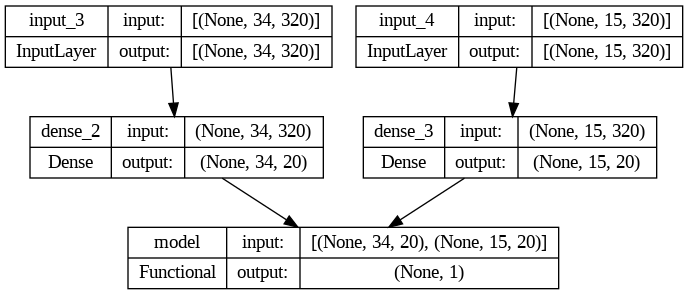

In [76]:
from tensorflow.keras.utils import plot_model

plot_model(new_model, to_file='model.png', show_shapes=True, show_layer_names=True)

### Train the model

In [77]:
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.callbacks as Callbacks

mhcglobe_callbacks = [Callbacks.EarlyStopping(
                monitor='val_loss',
                patience=20,
                mode='min',
                baseline=1,
                min_delta=0.0001)]
verbose = 0

new_model.fit([training_allele_BERT_embeddings, training_peptide_BERT_embeddings], Y_tr,
              batch_size= 1, #hparams['batch_size'], 300/10000
              epochs=300,
              validation_data=([es_allele_BERT_embeddings, es_peptide_BERT_embeddings], Y_es),
              shuffle=True,
              verbose=verbose,
              callbacks=mhcglobe_callbacks)

### Predict using this model!!!

In [84]:
test_allele_pseudoseqs = get_allele_pseudoseqs(human_pMHC_data_test, pMHC)
test_peptide_pseudoseqs = get_peptide_pseudoseqs(human_pMHC_data_test)

# for test: 5, 15, 320
test_allele_BERT_embeddings = get_BERT_embeddings(test_allele_pseudoseqs, tokenizer, model, "tf")
# for test: 5, 15, 320
test_peptide_BERT_embeddings = get_BERT_embeddings(test_peptide_pseudoseqs, tokenizer, model, "tf")

In [85]:
test_predictions = new_model.predict([test_allele_BERT_embeddings, test_peptide_BERT_embeddings])

4/4 [==============================] - 0s 3ms/step


In [86]:
test_predictions

array([[0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.57225055],
       [0.572